# Search and Impression Visualizations

### Author(s): [Ben Dykstra](https://github.com/bfdykstra)
### Date: July/August, 2016
### Tags: #data-science, #data-visualization, #search, #Product-saturation

***
###	TLDR:
This notebook shows how our searches and impressions (a user somehow saw the property on a webpage) are distributed throughout the United States, adding some location intelligence to what we are doing. It also gives us a sense of how much space super cities/metros occupy and their relationship to one another.
***

### Motivation

Ever wonder where the most popular place to search for a place to live is? What about the 50 most popular places?

Ever wonder if there are properties where those places are? 

**...read on....**

These are all utility things, pay them no mind

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon
from pandas.compat import range, lrange, lmap, map, zip, string_types
import pandas.compat as compat
from pandas.formats.printing import pprint_thing


%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 40, 20

In [2]:
# Lambert Conformal map of lower 48 states.
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

This is a shapefile of the United States state boundaries that can be downloaded from pretty much anywhere on the internet. The Census Bureau has a good one (https://www.census.gov/geo/maps-data/data/cbf/cbf_state.html), get the high resolution one labeled 20m.

In [6]:
shp_info = m.readshapefile('/Users/benjamin.dykstra/Documents/hot_prospects/us_map/st99_d00','states',drawbounds=False)

In [35]:
def map_zips(metric_dict, useBlue, data_min, data_max, title = 'map'):
    # choose a color for each state based on search density.
    from matplotlib.colors import Normalize
    colors={}
    all_zips = []
    if useBlue:
        cmap = plt.cm.Blues
    else:
        cmap = plt.cm.Greens
    norm = Normalize(vmin = data_min, vmax = data_max)
    y = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

    #play with vmax depending on range of values for percentage
    vmin = 0; vmax = 1# set range.
    font = {
            'weight' : 'bold',
            'size'   : 30}
    plt.rc('font', **font)
    
    count = 0
    for shapedict in m.zip_codes_info:
        zipcode = shapedict['GEOID10']

        if zipcode in metric_dict:
            pop = metric_dict[zipcode]
            #print pop
            #pop = pop + 0.1
        else:
            count += 1
            pop = 0
        #print(np.log((pop)/(vmax)))
        # calling colormap with value between 0 and 1 returns
        # rgba value.  Invert color range (hot colors are high
        # population), take sqrt root to spread out colors more.
        #colors[zipcode] = cmap(1.-np.sqrt(pop))[:3]
        #colors[zipcode] = cmap(np.sqrt((pop)/(vmax)))[:3]
        colors[zipcode] = y.to_rgba(pop)

        all_zips.append(zipcode)
    print 'total count of missed zips: ', count
    ax = plt.gca() # get current axes instance
    ax.axis('off') #turns off weird box around the map
    
    # cycle through state names, color each one.
    for nshape,seg in enumerate(m.zip_codes):

        color = rgb2hex(colors[all_zips[nshape]])
        poly = Polygon(seg,facecolor=color,edgecolor=color)
        ax.add_patch(poly)

    # draw meridians and parallels.
    # m.drawparallels(np.arange(25,65,20),labels=[1,0,0,0])
    # m.drawmeridians(np.arange(-120,-40,20),labels=[0,0,0,1])
    m.drawmapboundary();
    plt.title(title);
    plt.show();

    
    

This data is compiled from the search data for june and is just search counts per a city along with the overall percentage of searches that it is.

In [8]:
sort = pd.read_csv('data/june_sorted.csv')
sort.head()

,index,state,metro,city,counts,percentage
0,2026,FL,MIAMI,NO_CITY,161490,0.014851
1,3079,IL,CHICAGO,NO_CITY,151067,0.013893
2,10261,TX,SAN+ANTONIO,NO_CITY,130773,0.012026
3,1101,CA,SAN+DIEGO,SAN+DIEGO,130269,0.011980
4,2456,GA,ATLANTA,NO_CITY,128427,0.011811


In [9]:
state_sort = sort.groupby(by = 'state').sum().reset_index().sort_values(by = 'counts', ascending = False).reset_index()

In [10]:
# need to create mapping from state abbreviation to actual state name, and leave out canada
states = {
    'AK': 'Alaska','AL': 'Alabama','AR': 'Arkansas','AZ': 'Arizona','CA': 'California','CO': 'Colorado',
    'CT': 'Connecticut','DC': 'District of Columbia','DE': 'Delaware','FL': 'Florida','GA': 'Georgia','HI': 'Hawaii',
    'IA': 'Iowa','ID': 'Idaho','IL': 'Illinois','IN': 'Indiana','KS': 'Kansas','KY': 'Kentucky','LA': 'Louisiana',
    'MA': 'Massachusetts','MD': 'Maryland','ME': 'Maine','MI': 'Michigan','MN': 'Minnesota','MO': 'Missouri',
    'MS': 'Mississippi','MT': 'Montana','NC': 'North Carolina','ND': 'North Dakota','NE': 'Nebraska',
    'NH': 'New Hampshire','NJ': 'New Jersey','NM': 'New Mexico','NV': 'Nevada','NY': 'New York','OH': 'Ohio',
    'OK': 'Oklahoma','OR': 'Oregon','PA': 'Pennsylvania','PR': 'Puerto Rico','RI': 'Rhode Island',
    'SC': 'South Carolina','SD': 'South Dakota','TN': 'Tennessee','TX': 'Texas','UT': 'Utah','VA': 'Virginia',
    'VI': 'Virgin Islands','VT': 'Vermont','WA': 'Washington','WI': 'Wisconsin','WV': 'West Virginia',
    'WY': 'Wyoming','AB': 'Alberta','BC': 'British Columbia','MB': 'Manitoba','NB': 'New Brunswick',
    'NL': 'Newfoundland and Labrador','NT': 'Northwest Territories','NS': 'Nova Scotia','NU': 'Nunavut',
    'ON': 'Ontario','PE': 'Prince Edward Island','QC': 'Quebec','SK': 'Saskatchewan','YT': 'Yukon'
}

In [11]:
state_sort['full_state'] = state_sort['state'].map(states)

In [12]:
#get slice of data frame for state name and the percentage is a dictionary
# http://stackoverflow.com/questions/18695605/python-pandas-dataframe-to-dictionary
search_state_popularity_percent = state_sort[['full_state', 'percentage']].set_index('full_state')['percentage'].to_dict()
search_popularity_raw = state_sort[['full_state', 'counts']].set_index('full_state')['counts'].to_dict()

In [15]:
# choose a color for each state based on population density.
colors={}
statenames=[]
cmap = plt.cm.Blues_r

vmin = 0; vmax = 0.08# set range.
font = {
        'weight' : 'bold',
        'size'   : 30}
plt.rc('font', **font)

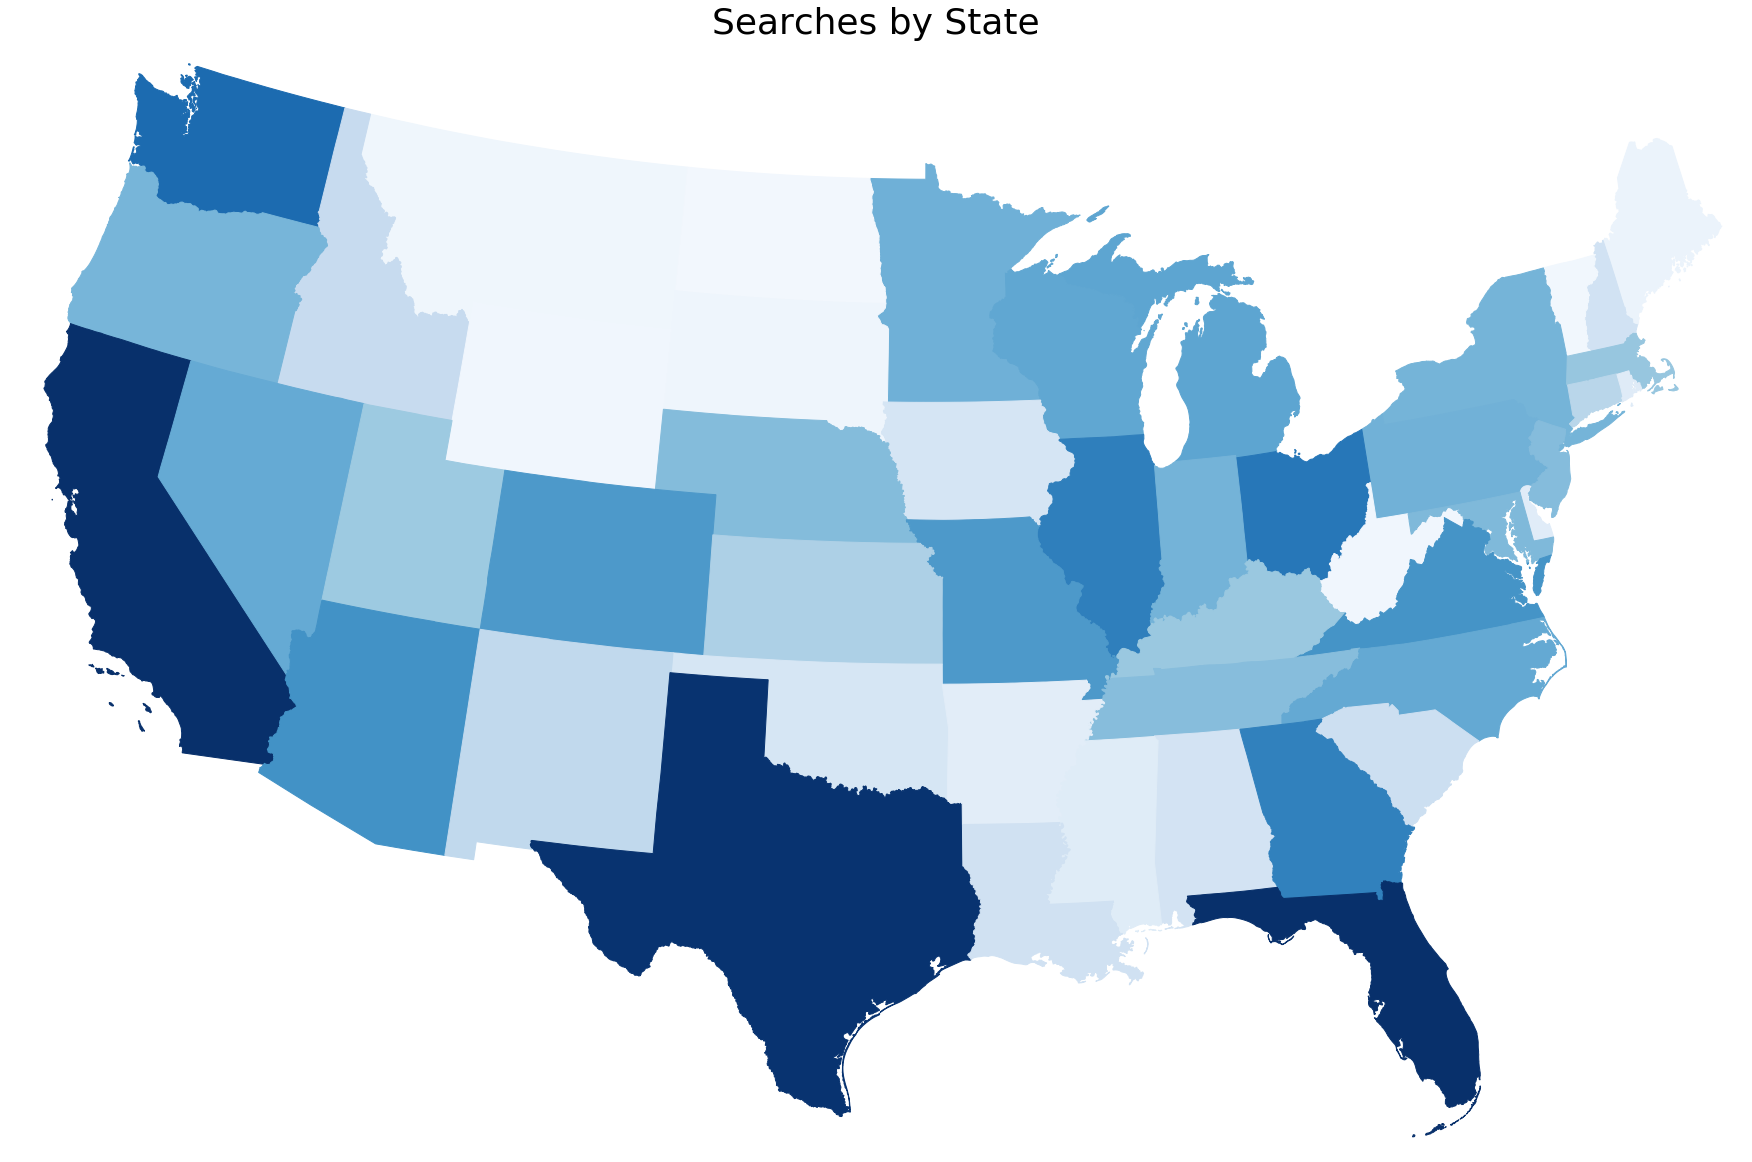

In [16]:
for shapedict in m.states_info:
    statename = shapedict['NAME']
    
    # skip DC and Puerto Rico.
    if statename not in ['District of Columbia','Puerto Rico']:
        pop = search_state_popularity_percent[statename]
        #print(np.log((pop)/(vmax)))
        # calling colormap with value between 0 and 1 returns
        # rgba value.  Invert color range (hot colors are high
        # population), take sqrt root to spread out colors more.
        colors[statename] = cmap(1.-np.sqrt((pop)/(vmax)))[:3]
    statenames.append(statename)
# cycle through state names, color each one.
ax = plt.gca() # get current axes instance
ax.axis('off') #turns off weird box around the map
for nshape,seg in enumerate(m.states):
    # skip DC and Puerto Rico.
    if statenames[nshape] not in ['District of Columbia','Puerto Rico']:
        color = rgb2hex(colors[statenames[nshape]]) 
        poly = Polygon(seg,facecolor=color,edgecolor=color)
        ax.add_patch(poly)
# draw meridians and parallels.
# m.drawparallels(np.arange(25,65,20),labels=[1,0,0,0])
# m.drawmeridians(np.arange(-120,-40,20),labels=[0,0,0,1])
m.drawmapboundary();
plt.title('Searches by State');
plt.show();


As you can see, California, Texas and Florida are the most searched states.

A zip code shape file of the United states can also be found on the census bureau's website. (https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html) Again, get the high resolution one.

In [17]:
zip_shp_info = m.readshapefile('/Users/benjamin.dykstra/Documents/featured-simulation/shape_files/'
                                'us_zips/cb_2015_us_zcta510_500k/cb_2015_us_zcta510_500k','zip_codes',drawbounds=False)

This is almost exactly the same file as the previous search file, with the exception that now every search has a super city id mapped to it. 

Then, using the standard mapping file, I map every search with an area to a collection of zip codes so that I can map it using the zip code shapefile.

In [18]:
super_w_counts = pd.read_csv('/Users/benjamin.dykstra/Documents/featured-simulation/data/june_super_city_w_counts.csv')
super_w_counts['zip_codes'] = np.nan

Need to map super city to a collection of zip codes, and city to zip codes

In [19]:
mapping = pd.read_csv('/Users/benjamin.dykstra/Documents/featured-simulation/data/Mapping_for_Geography.csv', header = None, 
                      names = ['zip_code', 'state_code', 'metro', 'custom_area_id', 'area_name', 'super_city_id', 
                               'city_name', 'preferred_as'])

#convert city name and state_code to uppercase, so it can match with search data
mapping.city_name = mapping.city_name.str.upper()
mapping.metro = mapping.metro.str.upper()
mapping.state_code = mapping.state_code.str.upper()

super_to_zip = {}
for row in mapping.values:
    if row[5] in super_to_zip:
        zip_list = super_to_zip[row[5]]
        if row[0] not in zip_list:
            zip_list.append(row[0])
    else:
        super_to_zip[row[5]] = [row[0]]
        
city_to_zip = {}
for row in mapping.values:
    st_met_city = row[1] + ', ' + row[2] + ', ' + row[6]
    if st_met_city in city_to_zip:
        list_zips = city_to_zip[st_met_city]
        if row[0] not in list_zips:
            city_to_zip[st_met_city].append(row[0])
    else:
        city_to_zip[st_met_city] = [row[0]]

Function to get list of zip codes within each area

In [20]:
#for row in super_w_counts.values[:50]:
def get_super_zips(my_ids):
    #super_ids = row[4] #list
    #print my_ids
    zip_list = []
    
    
    #print row[5]
    if my_ids in super_to_zip:
        super_zips = super_to_zip[my_ids] #list of zip codes from dictionary lookup
        for i in super_zips:
            zip_list.append(i)
    else:
        print my_ids
        return np.nan

    return zip_list
    
        #print row[5]

In [22]:
super_w_counts['zip_codes'] = super_w_counts['super_city_id'].apply(get_super_zips)
super_w_counts = super_w_counts[super_w_counts.zip_codes.notnull()]


need to stack up by zip code, so I can map a zip code to a search count/ percentage

In [23]:
super_w_counts['percentage'] = super_w_counts['counts'].div(super_w_counts['counts'].sum())


This changes the structure of the data frame so that every row is a different zipcode

In [24]:
rows = []
_ = super_w_counts.apply(lambda row: [rows.append([row['state'], row['metro'], row['city'], row['counts'], row['percentage'], row['super_city_id'], zip_code]) 
                         for zip_code in row.zip_codes], axis=1)
exploded_zips = pd.DataFrame(rows, columns = ['state', 'metro', 'city', 'counts', 'percentage', 'super_city_id', 'zip_code'])


In [25]:
exploded_zips.head()

,state,metro,city,counts,percentage,super_city_id,zip_code
0,AK,NORTH CENTRAL ALASKA,ANCHORAGE,792,0.000016,1756.0,99501
1,AK,NORTH CENTRAL ALASKA,ANCHORAGE,792,0.000016,1756.0,99502
2,AK,NORTH CENTRAL ALASKA,ANCHORAGE,792,0.000016,1756.0,99503
3,AK,NORTH CENTRAL ALASKA,ANCHORAGE,792,0.000016,1756.0,99504
4,AK,NORTH CENTRAL ALASKA,ANCHORAGE,792,0.000016,1756.0,99505


In [32]:
grouped_zips = exploded_zips.groupby(by = ['zip_code'], as_index = False).sum()

In [33]:
#sets up a dictionary with zip code as key and percentage/ count as value
search_zip_popularity_percent = grouped_zips[['zip_code', 'percentage']].set_index('zip_code')['percentage'].to_dict()
search_zip_popularity_raw = grouped_zips[['zip_code', 'counts']].set_index('zip_code')['counts'].to_dict()

This gives us the top 20 most popular zip codes. zip codes 91976 are in San Diego.

In [34]:
grouped_zips.sort_values(by = 'percentage', ascending = False)

,zip_code,counts,percentage,super_city_id
37557,91976,308684,6.300856e-03,11401.0
37559,91978,308684,6.300856e-03,11401.0
37552,91948,308684,6.300856e-03,11401.0
37611,92072,308684,6.300856e-03,11401.0
37555,91962,308684,6.300856e-03,11401.0
37556,91963,308684,6.300856e-03,11401.0
37610,92071,308684,6.300856e-03,11401.0
37558,91977,308684,6.300856e-03,11401.0
37560,91979,308684,6.300856e-03,11401.0
37549,91944,308684,6.300856e-03,11401.0


## Searches by Super City

total count of missed zips:  407


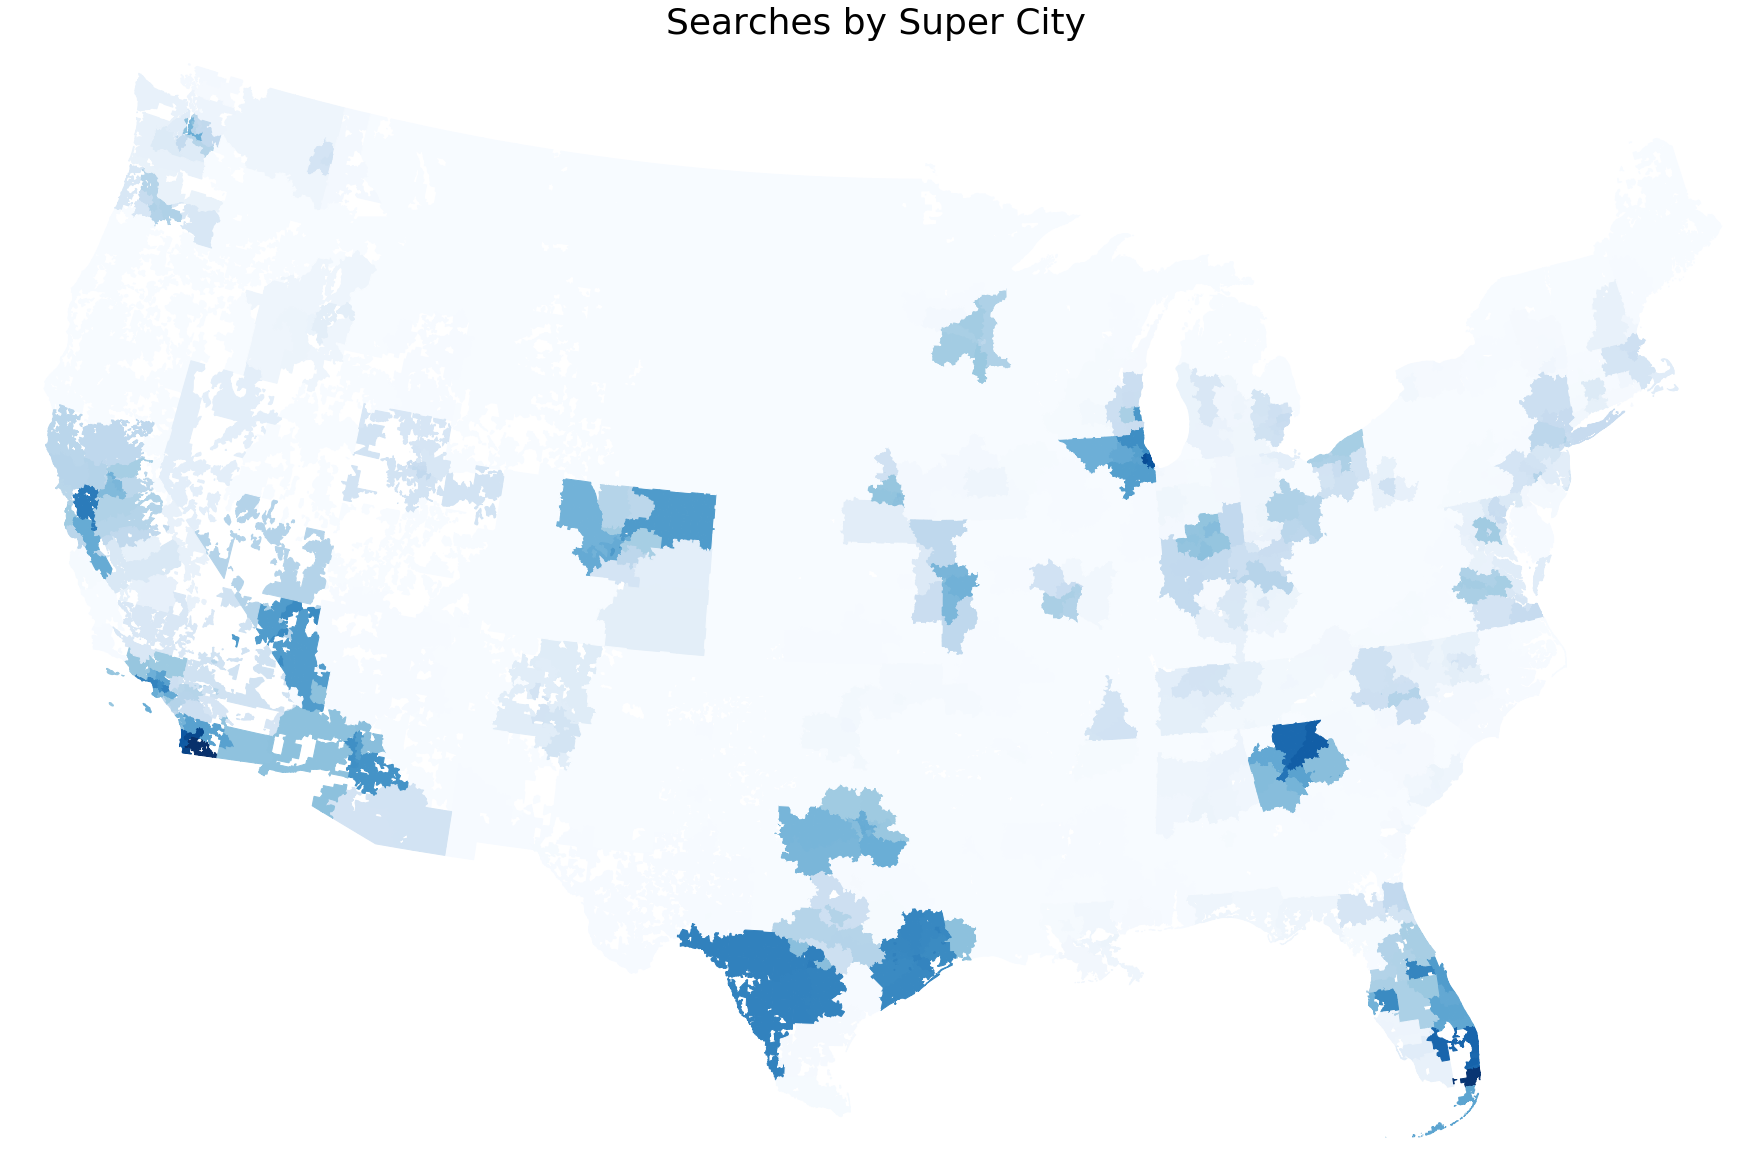

In [36]:
map_zips(search_zip_popularity_percent, True, grouped_zips.percentage.min(), grouped_zips.percentage.max(), title = 'Searches by Super City')

San Diego is the most searched for Super City, with Miami as runner up. The absolutely white areas are places where there are no zipcodes in our database.

## Map out featured Property Impressions by Super city

This map shows what our impressions look like in the US.

In [37]:
impress = pd.read_csv('/Users/benjamin.dykstra/Documents/featured-simulation/data/site_impressions.csv')
impress.head()

,Featured_Site_Id,Property_Name,Super_City_Id,Current_Targeted_Area,Recommended_Targeted_CityState,Physical_Location_CityState,Physical_Location_Metro,Featured_Property_Impression,Featured_Property_Interactions
0,12508,Northgreen,1062,Eugene,"Eugene, OR","Eugene, OR",Eugene-Springfield,19509,92
1,13513,Hidden Lake Apartments,858,Somerset,"Somerset, NJ","North Brunswick, NJ",Central New Jersey,14678,95
2,13628,Whitnall Pointe Apartment Homes,718,Milwaukee County,"Milwaukee, WI","Franklin, WI",Milwaukee,25782,67
3,14001,Mission Hills,948,Vancouver,"Vancouver, WA","Vancouver, WA",Portland,17730,81
4,35154,Northbrooke Township,926,Northeast Baltimore,"Parkville, MD","Parkville, MD",Baltimore,6173,41


In [38]:
#apply get_super_zips function 
impress['zip_codes'] = impress['Super_City_Id'].apply(get_super_zips)

In [39]:
#explode out zip codes
rows = []
_ = impress.apply(lambda row: [rows.append([row['Featured_Site_Id'], row['Super_City_Id'], row['Featured_Property_Impression'], 
                                            row['Featured_Property_Interactions'], zip_code]) 
                         for zip_code in row.zip_codes], axis=1)
impress_exploded = pd.DataFrame(rows, columns = ['featured_site_id', 'super_city_id', 'featured_property_impression', 
                                                 'featured_property_interactions', 'zip_code'])

In [41]:
impress_grouped = impress_exploded.groupby(by = ['zip_code'], as_index = False).sum().drop(['featured_site_id', 'super_city_id'], axis = 1)

In [42]:
#sets up a dictionary with zip code as key and percentage/ count as value
zip_impressions = impress_grouped[['zip_code', 'featured_property_impression']].set_index('zip_code')['featured_property_impression'].to_dict()
zip_interact = impress_grouped[['zip_code', 'featured_property_interactions']].set_index('zip_code')['featured_property_interactions'].to_dict()

## Impressions of Featured Properties by Super City

total count of missed zips:  27585


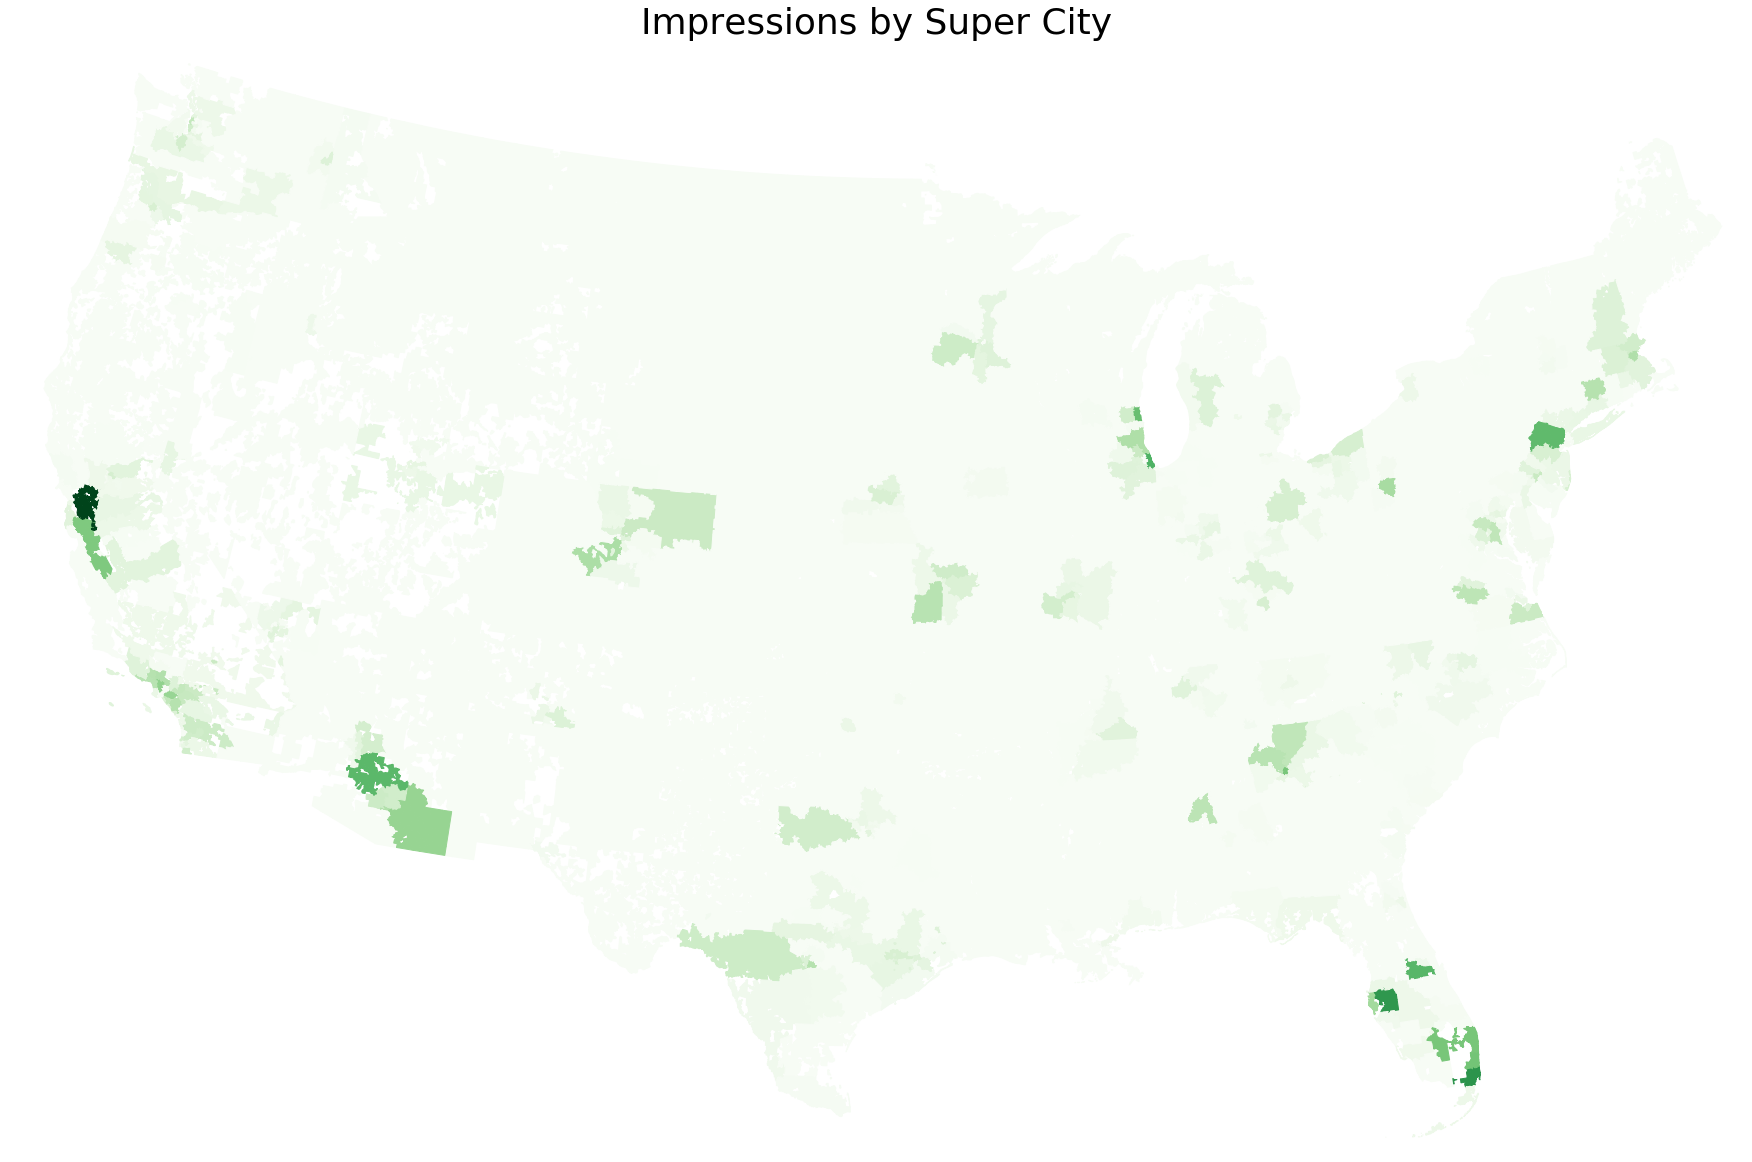

In [43]:
map_zips(zip_impressions, False,impress_grouped['featured_property_impression'].min(), impress_grouped['featured_property_impression'].max(), title = 'Impressions by Super City' )

San Fransisco super city actually gets the most impressions.

## Simulated impressions to featured property's physical location

In [50]:
sim_impress = pd.read_csv('/Users/benjamin.dykstra/Documents/featured-simulation/data/simulated_impressions_by_physical_city.csv')
sim_impress.physical_location = sim_impress.physical_location.str.upper()
sim_impress.physical_location = sim_impress.physical_location.str.strip()
sim_impress.head()

,actual_impress,featured_site_id,metro,physical_location,sim_impress,super_city_id,difference
0,10478,52396,"NM, ALBUQUERQUE","NM, ALBUQUERQUE, ALBUQUERQUE",7674,536,-2804
1,10723,52461,"NM, ALBUQUERQUE","NM, ALBUQUERQUE, RIO RANCHO",5774,536,-4949
2,10662,52750,"NM, ALBUQUERQUE","NM, ALBUQUERQUE, RIO RANCHO",5718,536,-4944
3,10388,52792,"NM, ALBUQUERQUE","NM, ALBUQUERQUE, RIO RANCHO",5846,536,-4542
4,10889,52915,"NM, ALBUQUERQUE","NM, ALBUQUERQUE, ALBUQUERQUE",7720,536,-3169


In [51]:
#for row in super_w_counts.values[:50]:
def get_city_zips(my_city):
    
    #super_ids = row[4] #list
    #print my_city
    zip_list = []
    
    
    #print row[5]
    if my_city in city_to_zip:
        city_zips = city_to_zip[my_city] #list of zip codes from dictionary lookup
        for i in city_zips:
            zip_list.append(i)
    else:
        print my_city
        return np.nan

    return zip_list

In [52]:
sim_impress['zip_codes_city'] = sim_impress.physical_location.apply(get_city_zips)
sim_impress = sim_impress[sim_impress.zip_codes_city.notnull()]

CA, ORANGE COUNTY, ANAHEIM HILLS
CA, SAN DIEGO, RANCHO BERNARDO
MD, BALTIMORE, JOPPATOWNE
MO, ST LOUIS, ST LOUIS


In [54]:
rows = []
_ = sim_impress.apply(lambda row: [rows.append([row['physical_location'], row['super_city_id'], row['sim_impress'], row['actual_impress'], zip_code]) 
                         for zip_code in row.zip_codes_city], axis=1)
physical_zips = pd.DataFrame(rows, columns = ['physical_location', 'super_city_id', 'sim_impress', 'actual_impress', 'zip_codes_city'])
physical_zips.zip_codes_city = physical_zips.zip_codes_city.str.strip()

In [55]:
physical_grouped_zips = physical_zips.groupby(by = 'zip_codes_city', as_index = False).sum().drop('super_city_id', axis = 1)

In [56]:
physical_dict = physical_grouped_zips[['zip_codes_city','sim_impress']].set_index('zip_codes_city')['sim_impress'].to_dict()
actual_impress_dict = physical_grouped_zips[['zip_codes_city','actual_impress']].set_index('zip_codes_city')['actual_impress'].to_dict()

total count of missed zips:  37629


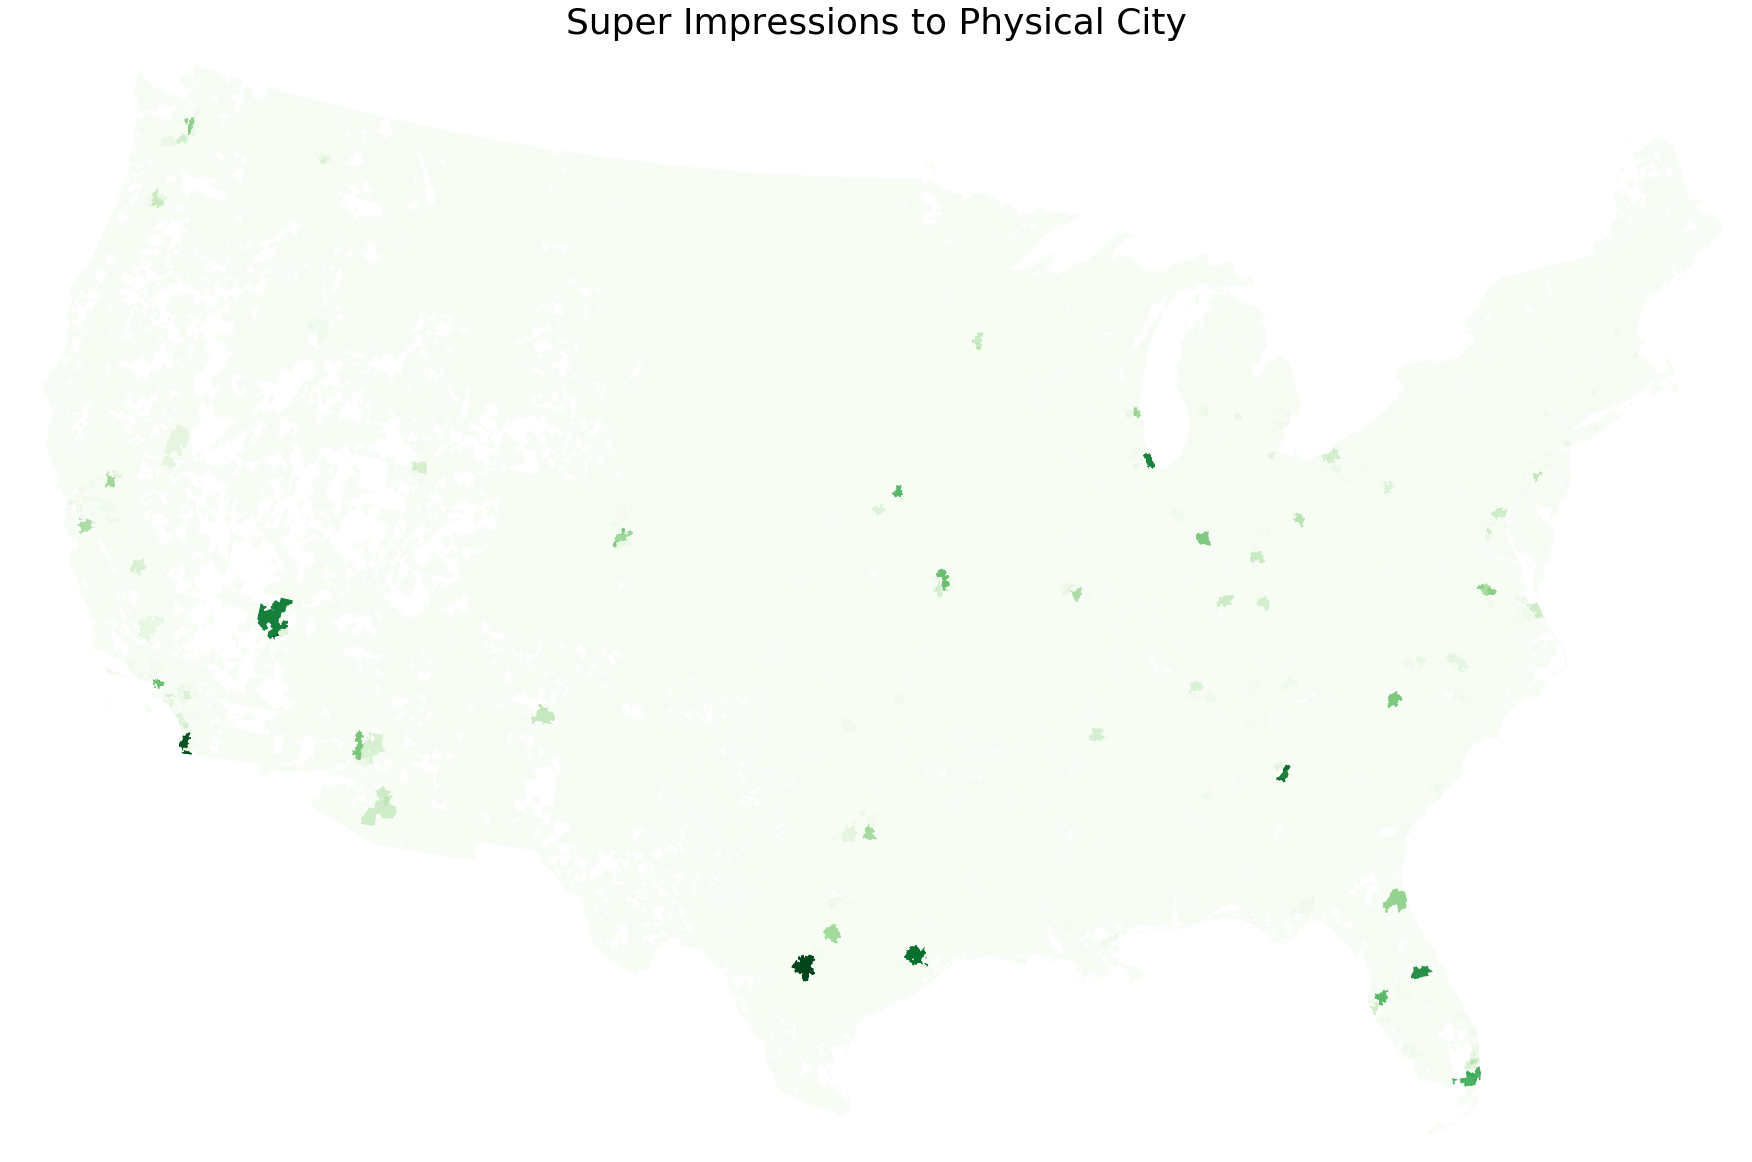

In [57]:
map_zips(physical_dict, False, physical_grouped_zips['sim_impress'].min(), physical_grouped_zips['sim_impress'].max(), title = 'Super Impressions to Physical City' ) 

The area that each search exposes is much smalled, therefore featured proprties get fewer impressions total. However, there's also a lot of room for market expansion then.

In [58]:
physical_zips.sim_impress.describe()

count    47254.000000
mean     20456.369260
std      11854.495005
min          0.000000
25%      12438.000000
50%      18957.000000
75%      26242.000000
max      94547.000000
Name: sim_impress, dtype: float64

## Conclusion

Theres a ton of searches in to southern Texas and not very many featured properties there. This happens in many places, but most notably here. Sales should be tailored to where there are searches.

### Acknowledgements

Shout out to the census bureau for it's shapefiles and matplotlib for having awesome plotting libraries. As always, shout out to Josiah because I feel compelled to shout him out because he's my manager.

If you'd like to talk with me (Ben Dykstra) more about this and have suggestions / comments / things I may have missed shoot me an email @ bfdykstra@email.wm.edu or just open an issue on github.

#### Future Directions

Add in metro simulated impressions, improve the search visualization to include labeled states etc. 
Show this to someone who might find it useful in decision making.

## the rest of this is just noodling around with Andrew's curves

if you care, it's really cool for discovering hidden structure in data, ie differentiating between top performers and pretty good performers.

In [59]:
def _get_standard_colors(num_colors=None, colormap=None, color_type='default',
                         color=None):
    import matplotlib.pyplot as plt

    if color is None and colormap is not None:
        if isinstance(colormap, compat.string_types):
            import matplotlib.cm as cm
            cmap = colormap
            colormap = cm.get_cmap(colormap)
            if colormap is None:
                raise ValueError("Colormap {0} is not recognized".format(cmap))
        colors = lmap(colormap, np.linspace(0, 1, num=num_colors))
    elif color is not None:
        if colormap is not None:
            warnings.warn("'color' and 'colormap' cannot be used "
                          "simultaneously. Using 'color'")
        colors = list(color) if is_list_like(color) else color
    else:
        if color_type == 'default':
            # need to call list() on the result to copy so we don't
            # modify the global rcParams below
            try:
                colors = [c['color']
                          for c in list(plt.rcParams['axes.prop_cycle'])]
            except KeyError:
                colors = list(plt.rcParams.get('axes.color_cycle',
                                               list('bgrcmyk')))
            if isinstance(colors, compat.string_types):
                colors = list(colors)
        elif color_type == 'random':
            import random

            def random_color(column):
                random.seed(column)
                return [random.random() for _ in range(3)]

            colors = lmap(random_color, lrange(num_colors))
        else:
            raise ValueError("color_type must be either 'default' or 'random'")

    if isinstance(colors, compat.string_types):
        import matplotlib.colors
        conv = matplotlib.colors.ColorConverter()

        def _maybe_valid_colors(colors):
            try:
                [conv.to_rgba(c) for c in colors]
                return True
            except ValueError:
                return False

        # check whether the string can be convertable to single color
        maybe_single_color = _maybe_valid_colors([colors])
        # check whether each character can be convertable to colors
        maybe_color_cycle = _maybe_valid_colors(list(colors))
        if maybe_single_color and maybe_color_cycle and len(colors) > 1:
            msg = ("'{0}' can be parsed as both single color and "
                   "color cycle. Specify each color using a list "
                   "like ['{0}'] or {1}")
            raise ValueError(msg.format(colors, list(colors)))
        elif maybe_single_color:
            colors = [colors]
        else:
            # ``colors`` is regarded as color cycle.
            # mpl will raise error any of them is invalid
            pass

    if len(colors) != num_colors:
        multiple = num_colors // len(colors) - 1
        mod = num_colors % len(colors)

        colors += multiple * colors
        colors += colors[:mod]

    return colors

In [60]:
def andrews_curves(frame, class_column, ax=None, samples=200, color=None,
                   colormap=None, **kwds):
    """
    Generates a matplotlib plot of Andrews curves, for visualising clusters of
    multivariate data.
    Andrews curves have the functional form:
    f(t) = x_1/sqrt(2) + x_2 sin(t) + x_3 cos(t) +
           x_4 sin(2t) + x_5 cos(2t) + ...
    Where x coefficients correspond to the values of each dimension and t is
    linearly spaced between -pi and +pi. Each row of frame then corresponds to
    a single curve.
    Parameters:
    -----------
    frame : DataFrame
        Data to be plotted, preferably normalized to (0.0, 1.0)
    class_column : Name of the column containing class names
    ax : matplotlib axes object, default None
    samples : Number of points to plot in each curve
    color: list or tuple, optional
        Colors to use for the different classes
    colormap : str or matplotlib colormap object, default None
        Colormap to select colors from. If string, load colormap with that name
        from matplotlib.
    kwds: keywords
        Options to pass to matplotlib plotting method
    Returns:
    --------
    ax: Matplotlib axis object
    """
    from math import sqrt, pi
    import matplotlib.pyplot as plt

    def function(amplitudes):
        def f(t):
            x1 = amplitudes[0]
            result = x1 / sqrt(2.0)

            # Take the rest of the coefficients and resize them
            # appropriately. Take a copy of amplitudes as otherwise numpy
            # deletes the element from amplitudes itself.
            coeffs = np.delete(np.copy(amplitudes), 0)
            coeffs.resize(int((coeffs.size + 1) / 2), 2)

            # Generate the harmonics and arguments for the sin and cos
            # functions.
            harmonics = np.arange(0, coeffs.shape[0]) + 1
            trig_args = np.outer(harmonics, t)

            result += np.sum(coeffs[:, 0, np.newaxis] * np.sin(trig_args) +
                             coeffs[:, 1, np.newaxis] * np.cos(trig_args),
                             axis=0)
            return result
        return f

    n = len(frame)
    class_col = frame[class_column]
    classes = frame[class_column].drop_duplicates()
    df = frame.drop(class_column, axis=1)
    t = np.linspace(-pi, pi, samples)
    used_legends = set([])

    color_values = _get_standard_colors(num_colors=len(classes),
                                        colormap=colormap, color_type='random',
                                        color=color)
    colors = dict(zip(classes, color_values))
    if ax is None:
        ax = plt.gca(xlim=(-pi, pi))
    for i in range(n):
        row = df.iloc[i].values
        f = function(row)
        y = f(t)
        kls = class_col.iat[i]
        #label = pprint_thing(kls)

        ax.plot(t, y, color=colors[kls], **kwds)

    #ax.legend(loc='upper right')
    #ax.grid()
    return ax

In [62]:
parsed_june = pd.read_csv('/Users/benjamin.dykstra/Documents/hot_prospects/parse_urls/parsed_June_2016.csv')
parsed_june.head()


,state,metro,city,mean_max_price,mean_min_price,accepts_credit_card_payments_search,accepts_electronic_payments_search,air_conditioning_search,alarm_system_search,all_dogs_allowed_search,...,spa_search,utilities_included_search,verizon_fios_search,view_search,walk_in_closets_search,washer_dryer_hookup_search,washer_dryer_in_unit_search,wireless_internet_access_search,total_count,city_state
0,AB,CALGARY,CALGARY,1300.852273,394.318182,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,102.0,"CALGARY, AB"
1,AB,CALGARY,CANMORE,800.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,"CANMORE, AB"
2,AB,CALGARY,NO_CITY,1186.500000,365.384615,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,"NO_CITY, AB"
3,AB,CALGARY,RED+DEER,500.000000,350.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"RED DEER, AB"
4,AB,EDMONTON,EDMONTON,1226.265734,666.433566,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,157.0,"EDMONTON, AB"


In [63]:
floats_only = ['city_state', 'mean_max_price', 'mean_min_price',
       'accepts_credit_card_payments_search',
       'accepts_electronic_payments_search', 'air_conditioning_search',
       'alarm_system_search', 'all_dogs_allowed_search',
       'broadband_internet_access_search', 'business_center_onsite_search',
       'cable_or_satellite_search', 'cats_allowed_search',
       'ceiling_fan_search', 'club_house_search',
       'controlled_access_search', 'covered_lot_search',
       'disability_access_search', 'dishwasher_search',
       'door_attendant_search', 'elevator_search', 'extra_storage_search',
       'fireplace_search', 'fitness_center_search',
       'furnished_available_search', 'garages_search',
       'hablamos_espanol_search', 'hardwood_floor_search',
       'large_dogs_search', 'laundry_facility_search',
       'luxury_amenities_search', 'microwave_search',
       'patio_or_balcony_search', 'pets_allowed_search',
       'playground_search', 'pool_search', 'public_transportation_search',
       'short_term_lease_search', 'small_dogs_allowed_search',
       'smoke_free_community_search', 'spa_search',
       'utilities_included_search', 'verizon_fios_search', 'view_search',
       'walk_in_closets_search', 'washer_dryer_hookup_search',
       'washer_dryer_in_unit_search', 'wireless_internet_access_search',
       'total_count']

subset = ['city_state', 'mean_min_price','mean_max_price','total_count', 'small_dogs_allowed_search','utilities_included_search', 
           'washer_dryer_in_unit_search', 'cats_allowed_search','air_conditioning_search',
          'pets_allowed_search']

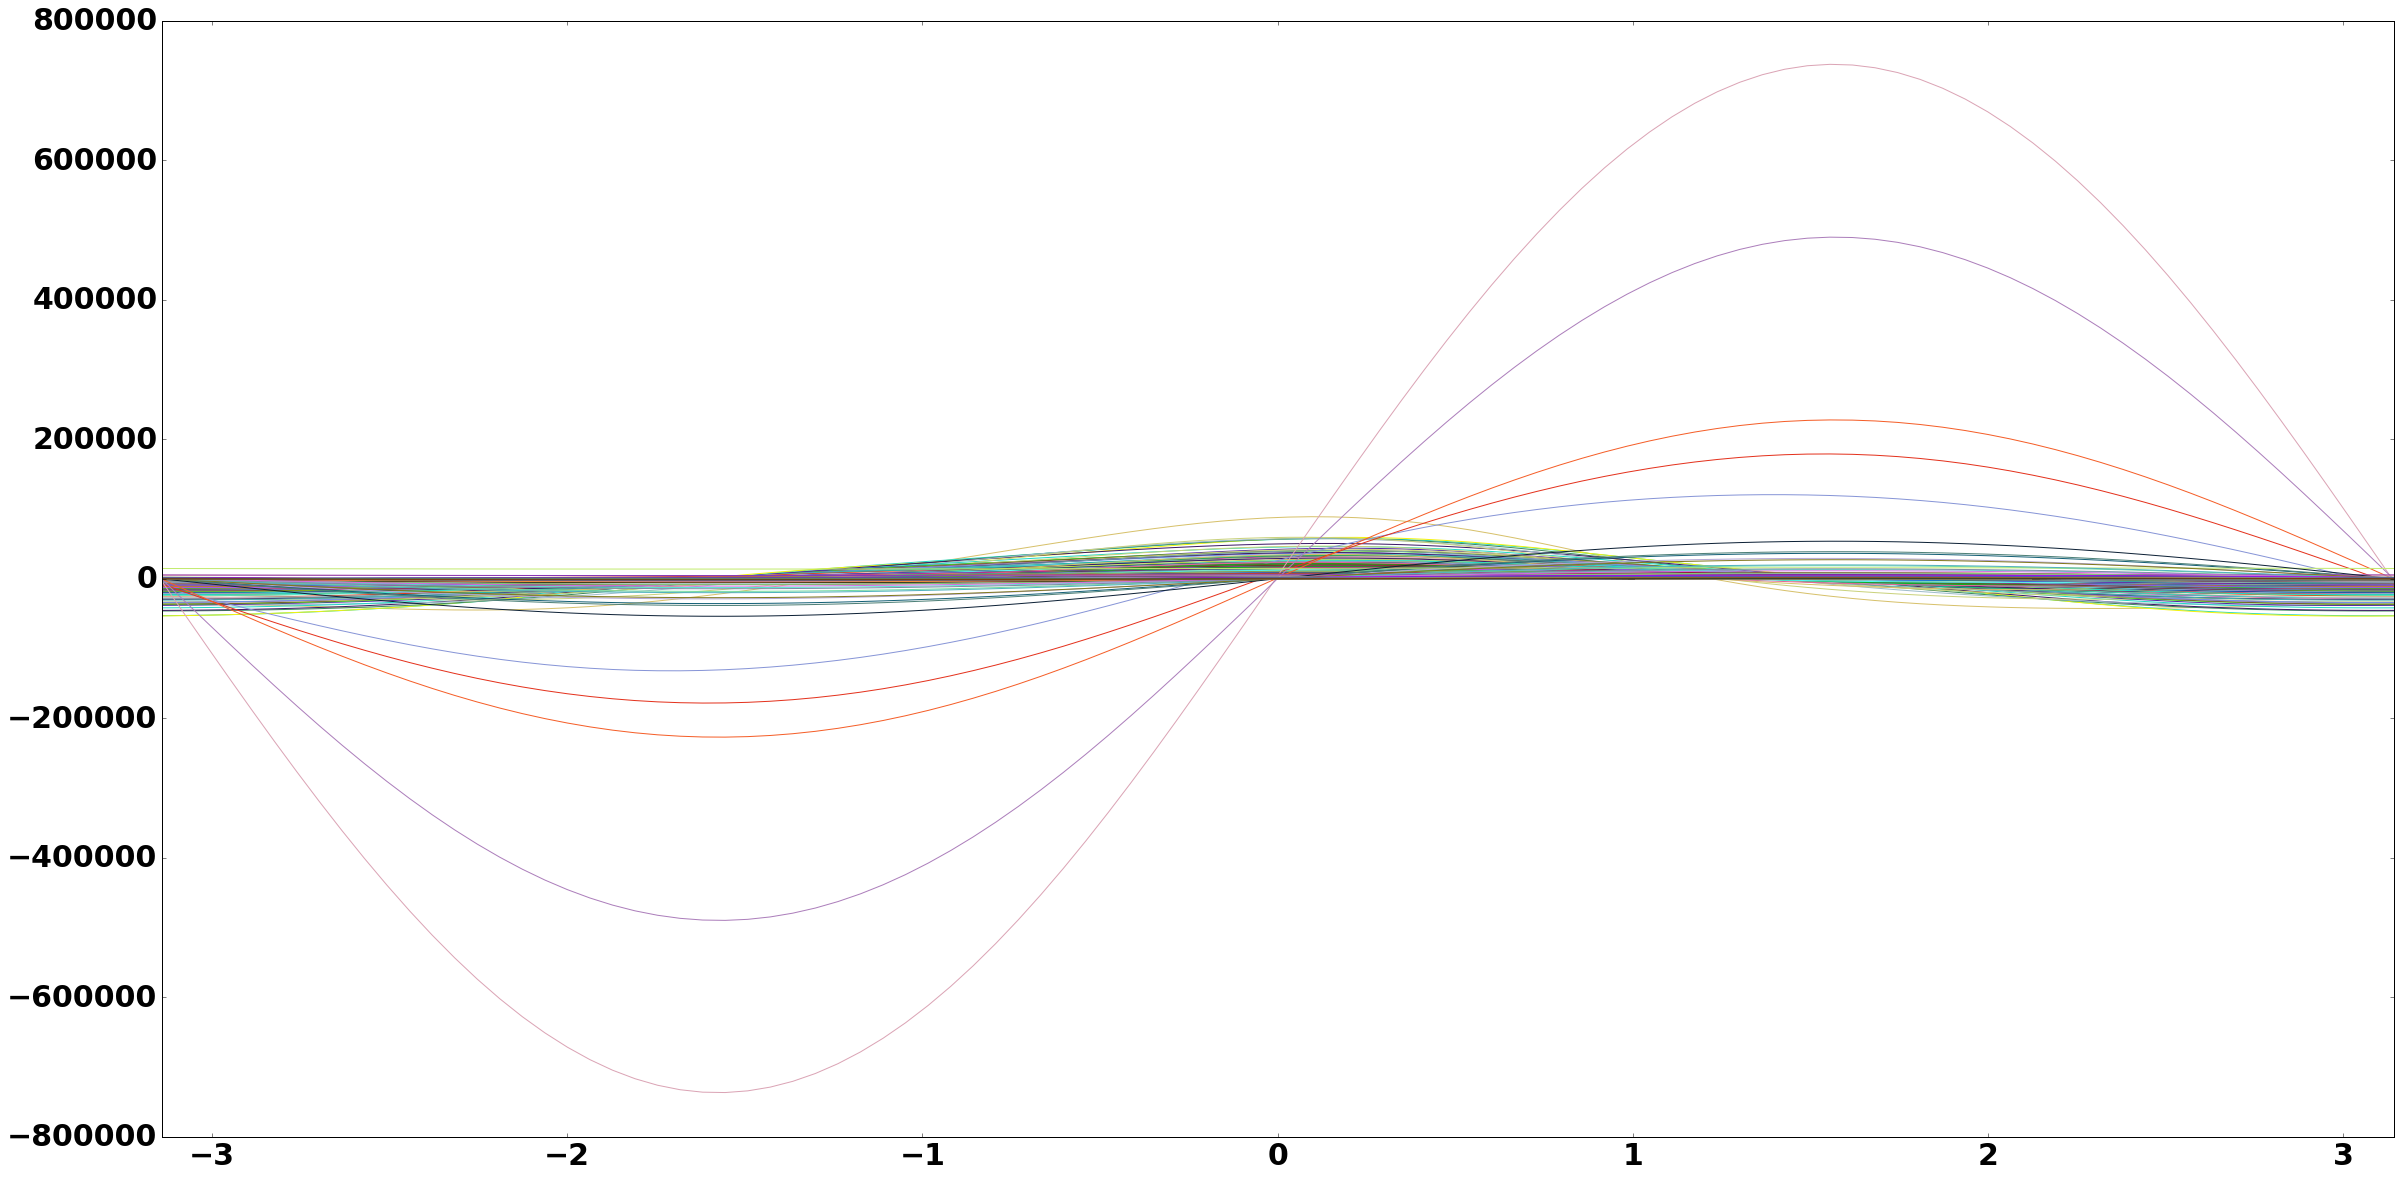

In [64]:
plt.figure()
andrews_curves(parsed_june.sort_values(by = 'total_count', ascending = False)[:][subset], 'city_state', samples = 100);


In [65]:
different = parsed_june.sort_values(by = 'total_count', ascending = False)[:5].append(parsed_june.sort_values(by = 'total_count', ascending = False)[50:70])

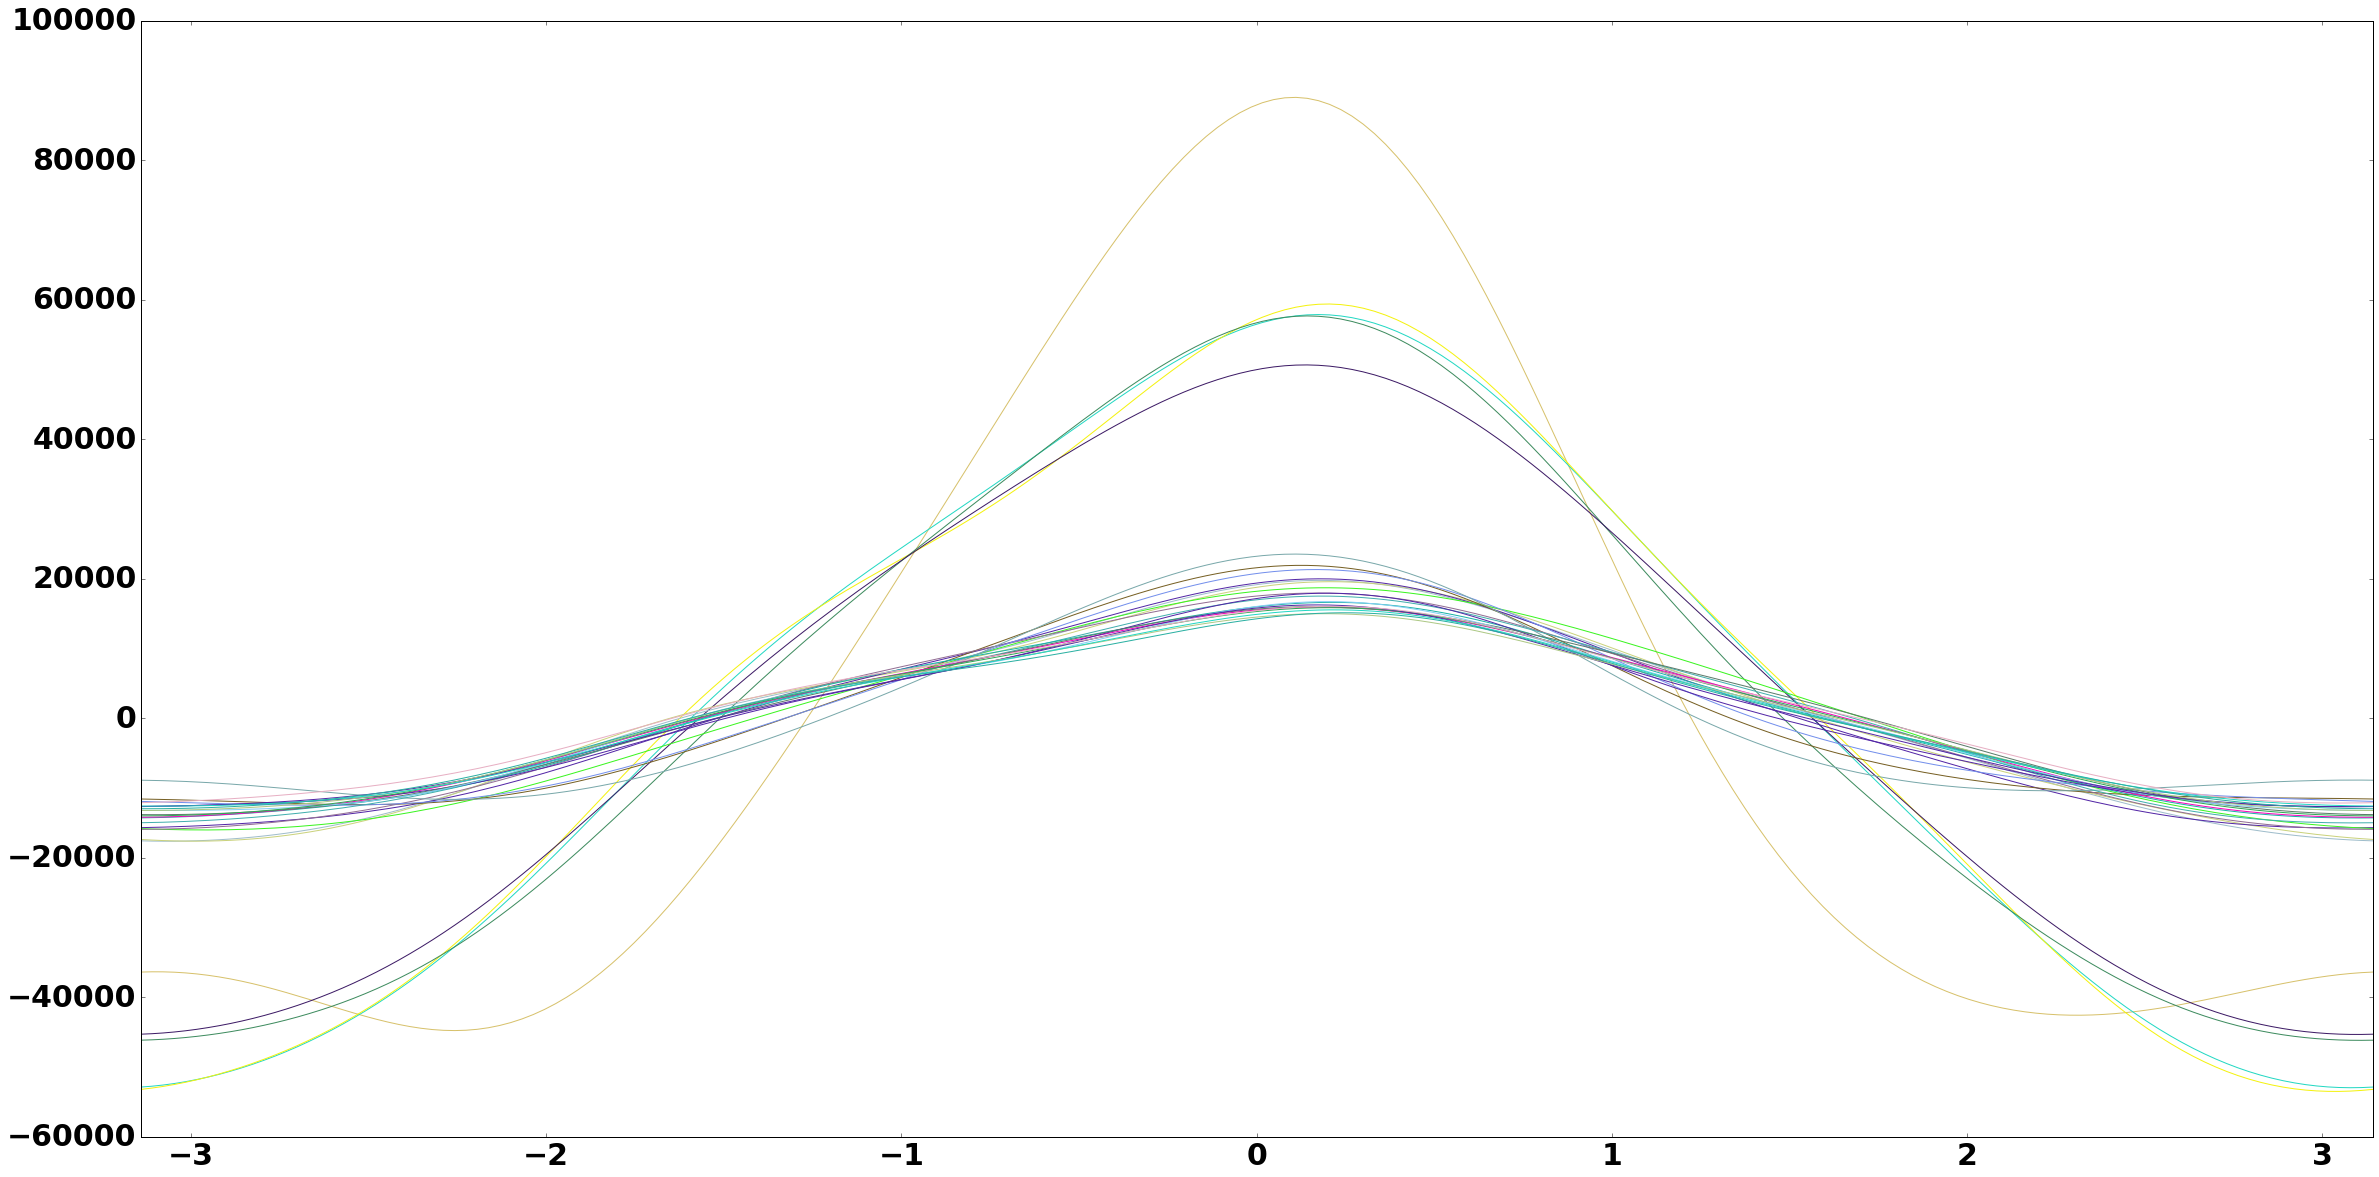

In [67]:
plt.figure()
andrews_curves(different[subset], 'city_state');

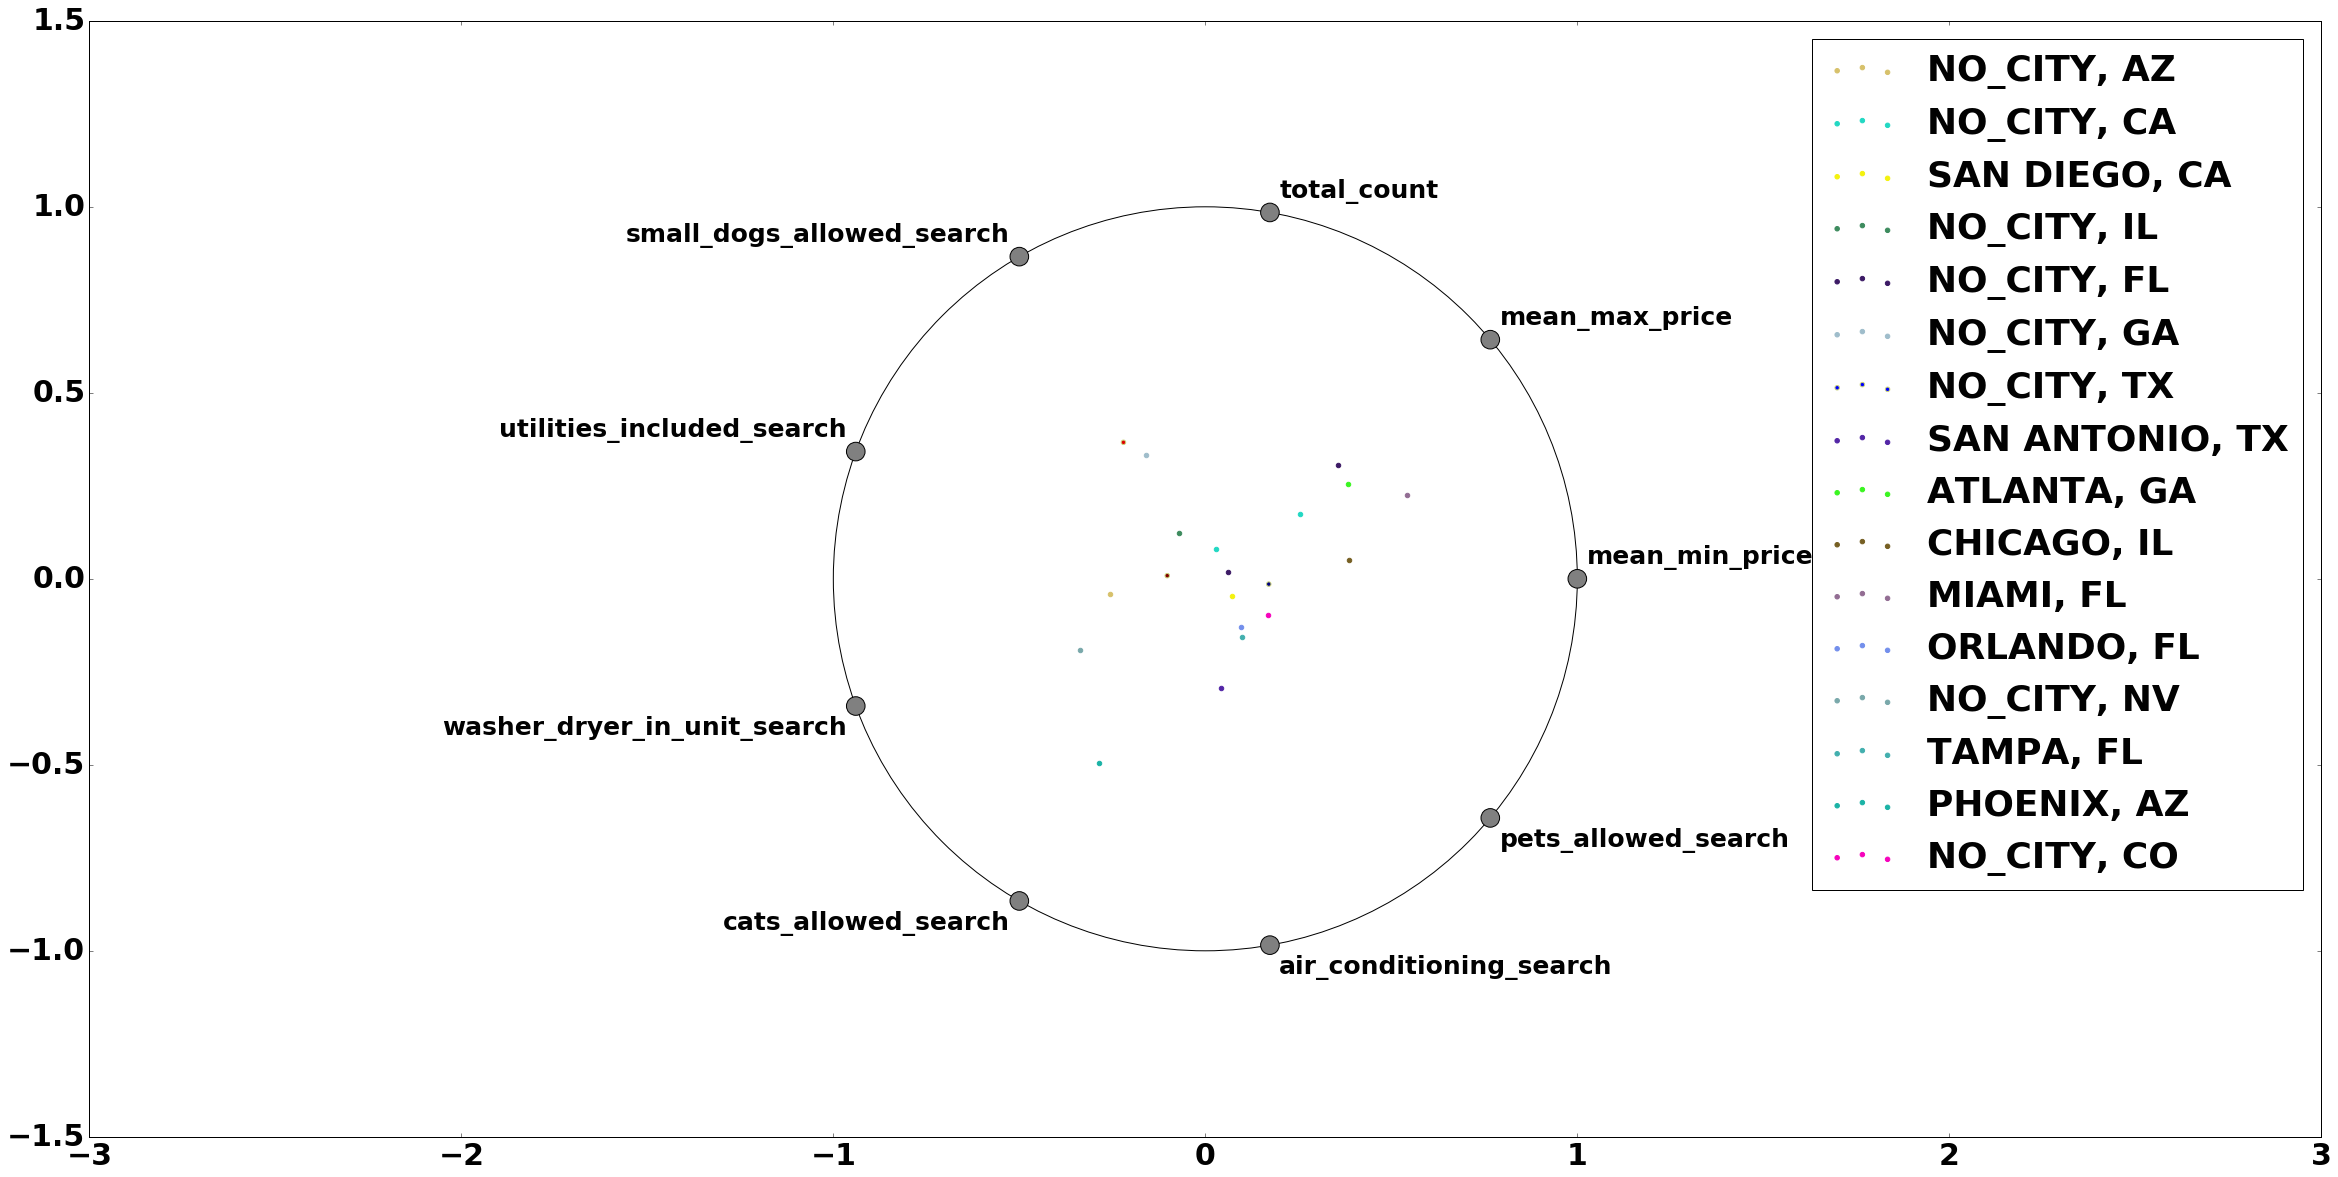

In [68]:
from pandas.tools.plotting import radviz
plt.figure()
radviz(parsed_june.sort_values(by = 'total_count', ascending = False)[:20][subset], 'city_state');